In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline
import seaborn as sns
from scipy.special import factorial
import math
from iminuit import cost, Minuit 
import numpy as np
import pickle

sns.set_context('talk', font_scale=1.0)
sns.set_palette('colorblind')

from depth_helpers import *

Cs_line = source_dict['Cs137']

datpath = '/home/cosilab/CalibrationData/CalibratedDATs/'
plot_dir = '/home/cosilab/CalibrationData/figures/preLL/'
AC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/Am241_AC_preLL_57to62keV/CTD_parameters.txt'
DC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/Am241_DC_preLL_57to62keV/CTD_parameters.txt'
CTD_sims = '/home/cosilab/COSITrapping/ctd_sims/CTD_HP414183.csv'
AC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_HP414183_ac.csv'
DC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_HP414183_dc.csv'
sim_dCCE = '/home/cosilab/COSITrapping/cce_sims/HP414183_dCCE_1000cm.csv'

calibrator = DepthCalibrator_Am241(AC_illumination_CTD, DC_illumination_CTD, AC_sim_events, DC_sim_events, CTD_sims)
sim_depth, sim_ctd = calibrator.get_simdata()

# plt.figure()
# plt.hist(calibrator.AC_sim_CTD + np.random.normal(loc=0.0, scale=21.9, size=calibrator.AC_sim_CTD.shape), bins=100, label='Extra noise')
# plt.hist(calibrator.DC_sim_CTD + np.random.normal(loc=0.0, scale=19.6, size=calibrator.DC_sim_CTD.shape), bins=100, color='C0')
# plt.hist(calibrator.AC_sim_CTD + np.random.normal(loc=0.0, scale=12.0, size=calibrator.AC_sim_CTD.shape), bins=100, histtype='step', color='red', label='Original noise')
# plt.hist(calibrator.DC_sim_CTD + np.random.normal(loc=0.0, scale=12.0, size=calibrator.DC_sim_CTD.shape), bins=100, histtype='step', color='red')
# plt.legend()
# plt.xlabel('CTD (ns)')
# plt.ylabel('Counts')
# plt.tight_layout()
# plt.savefig(plot_dir + 'sim_CTD_noise_comparison.pdf')

/home/cosilab/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cosilab/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [3]:
file_dict = {'Cs137': [['20231003_Cs137_AC_600V_1.dat', '20231003_Cs137_AC_600V_2.dat', '20231011_Cs137_AC_600V.dat', '20231020_Cs137_AC_600V.dat'], \
                       ['20230927_Cs137_DC_600V.dat', '20231006_Cs137_DC_600V_1.dat', '20231006_Cs137_DC_600V_2.dat', '20231023_Cs137_DC_600V.dat']], \
            'Ba133': [['20231005_Ba133_AC_600V.dat'], ['20231006_Ba133_DC_600V.dat']], \
            'Na22': [['20231024_Na22_AC_600V_1.dat', '20231024_Na22_AC_600V_2.dat', '20231026_Na22_AC_600V.dat'], \
                     ['20231024_Na22_DC_600V.dat', '20231025_Na22_DC_600V_1.dat', '20231025_Na22_DC_600V_2.dat', '20231026_Na22_DC_600V.dat']], \
            'Am241': [['20230920_Am241_AC_600V.dat', '20231026_Am241_AC_600V.dat'], \
                      ['20230922_Am241_DC_600V_1.dat', '20230922_Am241_DC_600V_2.dat']]}

erange_dict = {'Cs137': [630., 667.], 'Ba133': [330., 360.], 'Na22': [1220., 1290.], 'Am241': [50., 64.]}
zbin_dict = {'Cs137': np.linspace(calibrator.zmin, calibrator.zmax, 31), \
             'Ba133': np.linspace(calibrator.zmin, calibrator.zmax, 31), \
             'Na22': np.linspace(calibrator.zmin, calibrator.zmax, 31), \
             'Am241': np.linspace(calibrator.zmin, calibrator.zmax, 31)}

# Loop and make depth-calibrated dataframes

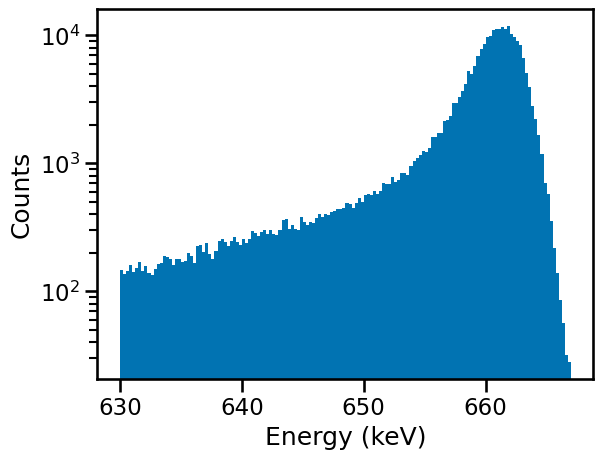

FWHM = 4.09
FWTM = 9.97


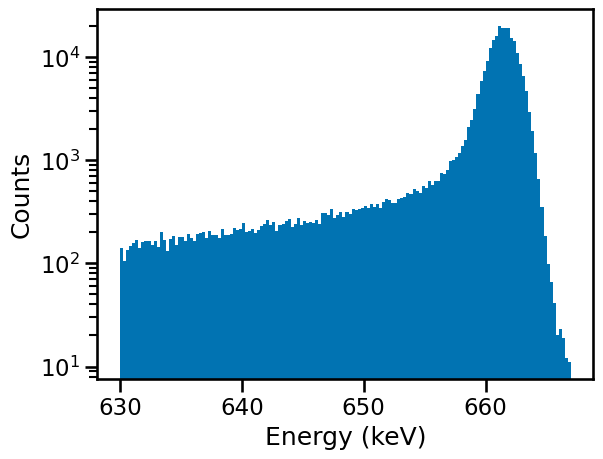

FWHM = 2.52
FWTM = 5.28


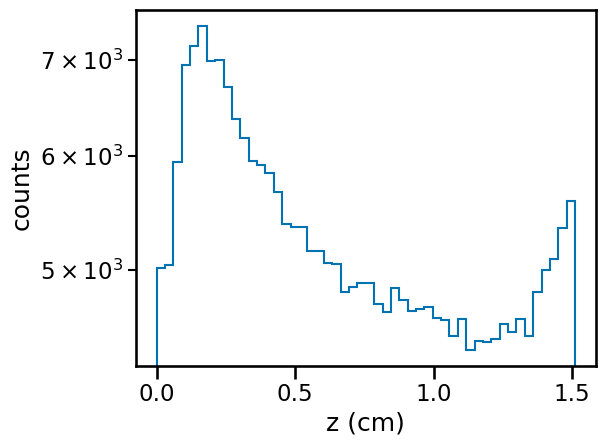

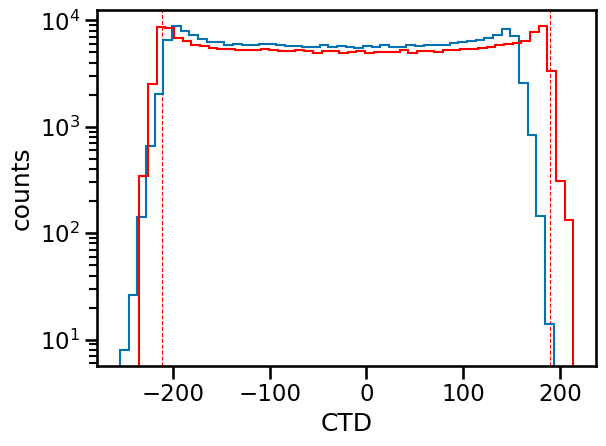

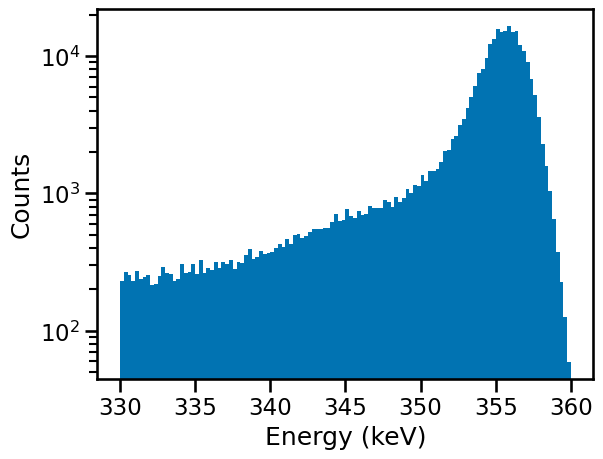

FWHM = 3.03
FWTM = 7.02


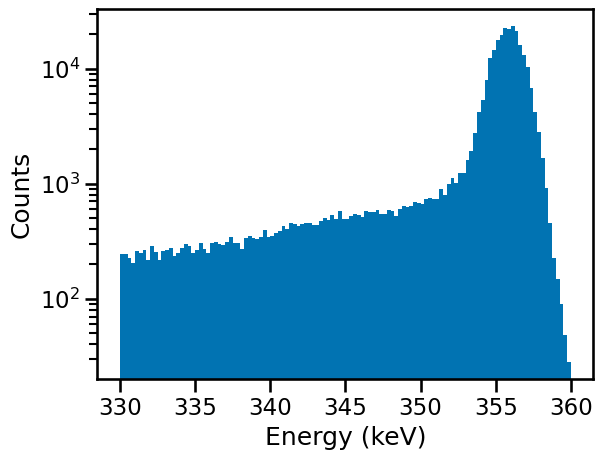

FWHM = 2.43
FWTM = 4.45


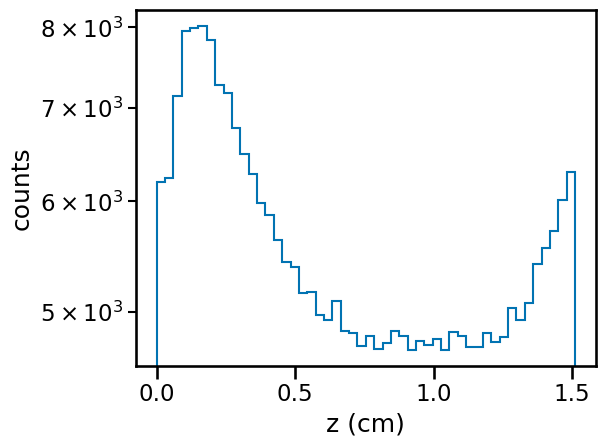

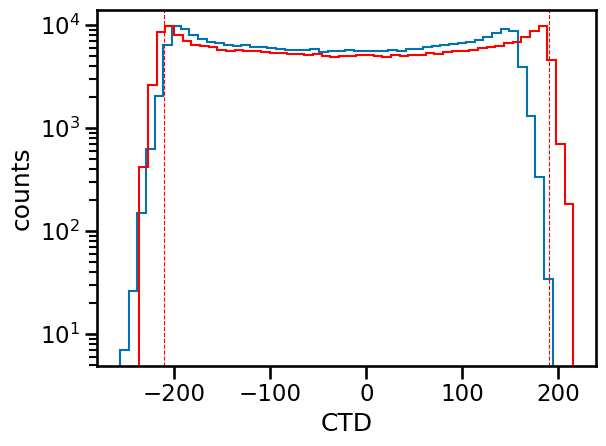

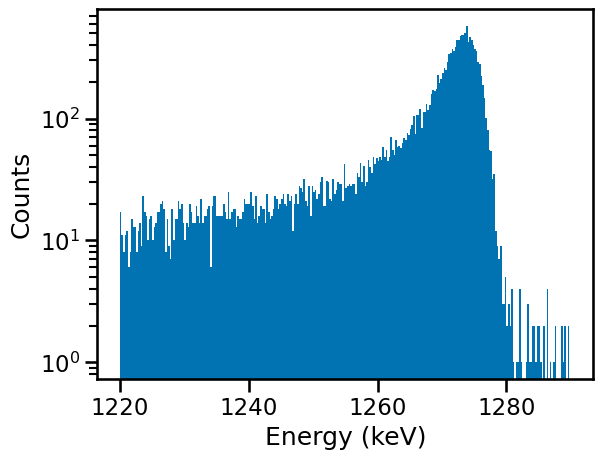

FWHM = 4.84
FWTM = 16.5


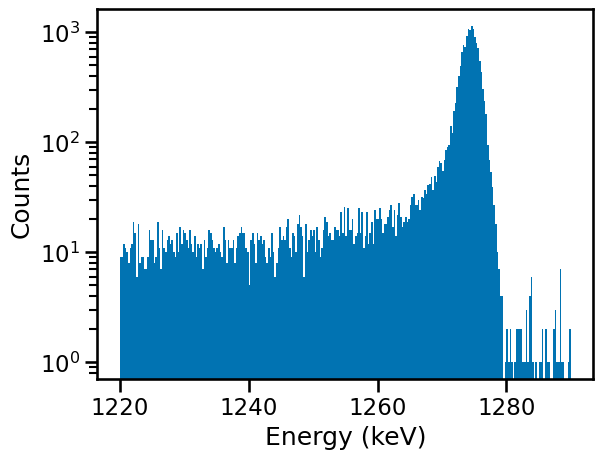

FWHM = 2.86
FWTM = 5.85


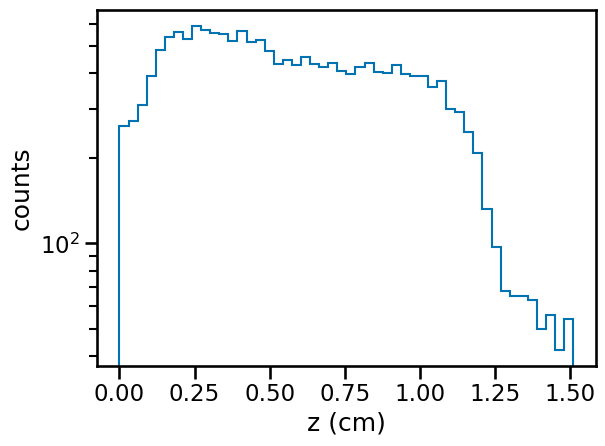

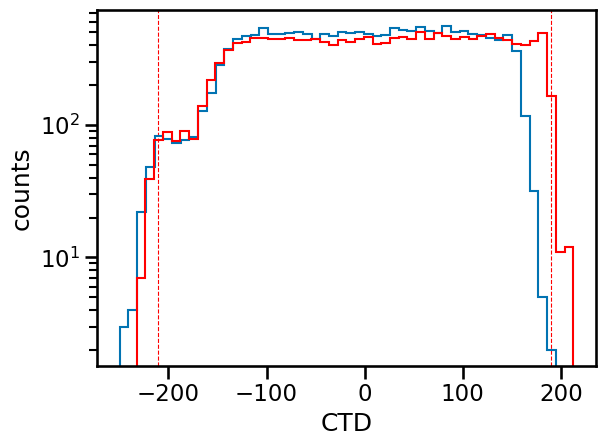

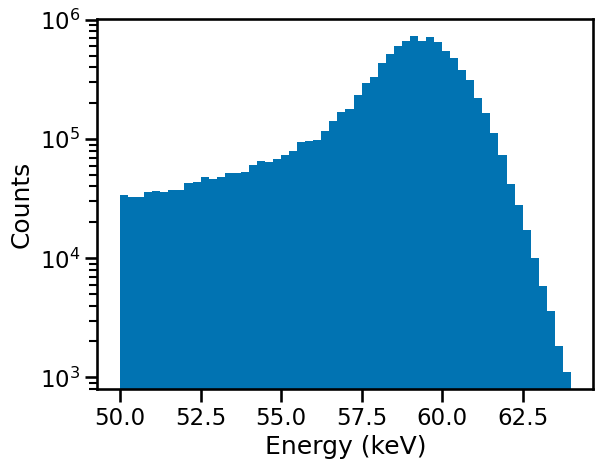

FWHM = 2.72
FWTM = 6.79


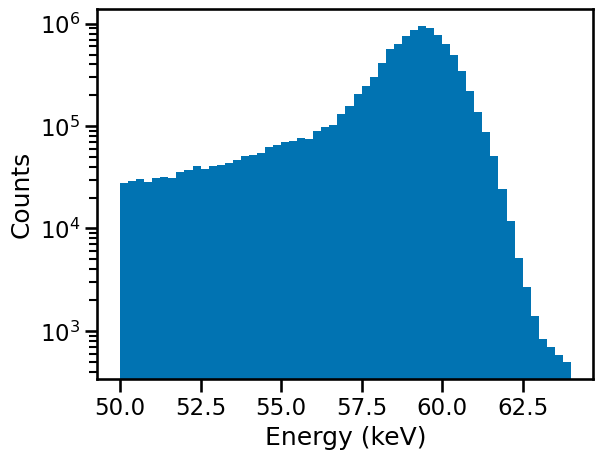

/home/cosilab/miniconda3/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


FWHM = 2.2
FWTM = 5.13


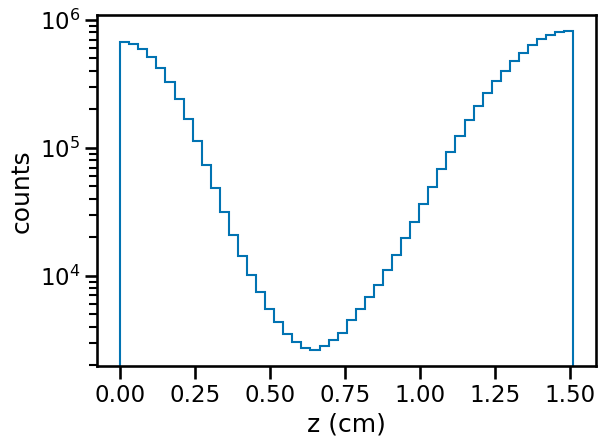

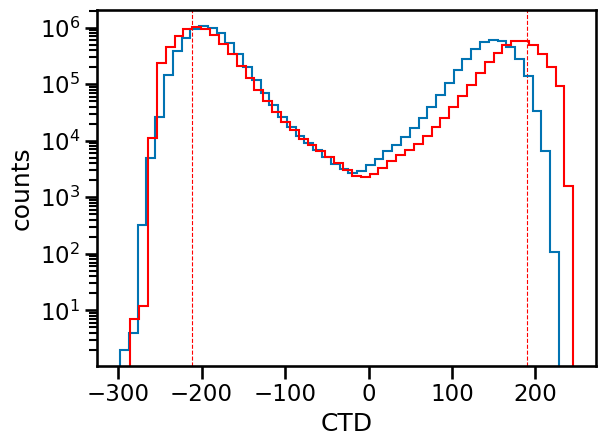

In [4]:
# AC_list = ['20231003_Cs137_AC_600V_1.dat', '20231003_Cs137_AC_600V_2.dat', '20231011_Cs137_AC_600V.dat', '20231020_Cs137_AC_600V.dat']
# DC_list = ['20230927_Cs137_DC_600V.dat', '20231006_Cs137_DC_600V_1.dat', '20231006_Cs137_DC_600V_2.dat', '20231023_Cs137_DC_600V.dat']
# allpaths = np.concatenate([AC_list, DC_list])
    
# path_lists = [AC_list, DC_list, allpaths]
# strings = ['Cs137allAC_preLL', 'Cs137allDC_preLL', 'Cs137allACandDC_preLL']

data_dict = {}
# for source in file_dict:
for source in file_dict:
    emin = erange_dict[source][0]
    emax = erange_dict[source][1]
    
    string = source + 'allACDC_preLL'
    
    ## Read in the dat files
    fullpaths = []
    for p in np.concatenate(file_dict[source]):
        fullpaths.append(datpath + 'preLL/' + p)
    
    df = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)
    bins = int((emax-emin) * 4)
    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_p'], bins=bins, range=(emin, emax))
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_n'], bins=binedges)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    ### Run depth calibration

    ctd_obs_map = [[[] for p in range(37)] for n in range(37)]
    ctd_stretch_map = [[[] for p in range(37)] for n in range(37)]
    ctd_obs_flat = []
    ctd_stretch_flat = []

    for p in range(37):
        for n in range(37):
            ctd_obs, ctd_stretch, depth, depth_err, bad = calibrator.depth_from_timing_prob(p+1, n+1, df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_p'], \
                                                                                       df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_n'], \
                                                                                      df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p'])
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z'] =  depth
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z_err'] =  depth_err
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'bad'] =  bad
            ctd_obs_map[p][n] = ctd_obs[~bad]
            ctd_stretch_map[p][n] = ctd_stretch[~bad]
            ctd_obs_flat.append(ctd_obs[~bad])
            ctd_stretch_flat.append(ctd_stretch[~bad])

    ctd_obs_flat = np.concatenate(ctd_obs_flat)
    ctd_stretch_flat = np.concatenate(ctd_stretch_flat)
    data_dict[source] = df
    
    plt.figure()
    plt.hist(df["z"], bins=50, histtype = "step", range=(calibrator.zmin,calibrator.zmax))
    plt.yscale('log')
    plt.xlabel("z (cm)")
    plt.ylabel("counts")
    plt.tight_layout()
    plt.savefig(plot_dir + 'depth_' + string + '_prob.pdf')

    plt.figure()
    plt.hist(ctd_obs_flat, bins=50, histtype="step", label="Observed CTD")
    plt.hist(ctd_stretch_flat, bins=50, histtype="step", color='red', label="stretched and shifted")
    plt.axvline(np.max(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.axvline(np.min(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.yscale('log')
    plt.xlabel('CTD')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.savefig(plot_dir + "CTD_" + string + ".pdf")

In [5]:
depth_plot_dict = {}
for source in data_dict:
    string = source + 'allACDC_preLL'
    z_bins, e_trapping, h_trapping = make_depthplot(data_dict[source], string, zbin_dict[source], source=source)
    depth_plot_dict[source] = z_bins, e_trapping, h_trapping
    depth_correction(data_dict[source], z_bins, e_trapping, h_trapping, plot_dir=plot_dir, plot_suffix = string, source = source)
    with open('./depth_plot_'+string+'.txt', 'wb') as file:
        pickle.dump([z_bins, e_trapping, h_trapping], file)

FWHM = 4.007+/-0.006
FWTM = 9.502+/-0.013
FWHM = 3.534+/-0.005
FWTM = 8.21+/-0.012
FWHM = 2.55+/-0.004
FWTM = 5.169+/-0.007
FWHM = 2.626+/-0.004
FWTM = 5.122+/-0.007
FWHM = 2.937+/-0.004
FWTM = 6.907+/-0.009
FWHM = 2.911+/-0.004
FWTM = 6.443+/-0.009
FWHM = 2.345+/-0.003
FWTM = 4.396+/-0.006
FWHM = 2.347+/-0.003
FWTM = 4.442+/-0.006


/home/cosilab/miniconda3/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/home/cosilab/COSITrapping/depth_helpers.py:631: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim((np.min(hist) + 10., 2.0*np.max(hist)))


FWHM = 4.888+/-0.028
FWTM = 16.359+/-0.093
FWHM = 4.606+/-0.026
FWTM = 13.717+/-0.078
FWHM = 3.01+/-0.017
FWTM = 5.919+/-0.033
FWHM = 2.802+/-0.016
FWTM = 5.862+/-0.033
FWHM = 2.731+/-0.001
FWTM = 6.826+/-0.002
FWHM = 2.735+/-0.001
FWTM = 6.66+/-0.001
FWHM = 2.164+/-0.0
FWTM = 5.069+/-0.001


/home/cosilab/miniconda3/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/home/cosilab/miniconda3/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


FWHM = 2.301+/-0.001
FWTM = 5.302+/-0.001


In [6]:
param_dict = {}
for source in data_dict:
    string = source + 'allACDC_preLL'
    m = fit_CCE(*depth_plot_dict[source], sim_dCCE, plot_dir=plot_dir, plot_suffix = string, trim_index = 1, source=source)
    depth_correction_CCE(data_dict[source], *m.values['ae','ah','b','c'], sim_dCCE, plot_dir=plot_dir, plot_suffix = string, source=source)
    param_dict[source] = m
    print(m)

FWHM = 3.91+/-0.005
FWTM = 9.805+/-0.014
FWHM = 3.492+/-0.005
FWTM = 8.219+/-0.011
FWHM = 2.582+/-0.004
FWTM = 5.206+/-0.007
FWHM = 2.597+/-0.004
FWTM = 5.132+/-0.007


/home/cosilab/miniconda3/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/home/cosilab/miniconda3/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 238 (chi2/ndof = 4.6)      │              Nfcn = 274              │
│ EDM = 4.57e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

/home/cosilab/miniconda3/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


FWHM = 2.145+/-0.0
FWTM = 4.861+/-0.001
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 997.1 (chi2/ndof = 19.2)   │              Nfcn = 260              │
│ EDM = 1.25e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────

In [7]:
for source in data_dict:
    string = source + 'allACDC_preLL_Cs137params'
    depth_correction_CCE(data_dict[source], *param_dict[source].values['ae','ah'], *param_dict['Cs137'].values['b','c'], sim_dCCE, plot_dir = plot_dir, plot_suffix = string, source=source)

FWHM = 3.91+/-0.005
FWTM = 9.805+/-0.014
FWHM = 3.492+/-0.005
FWTM = 8.219+/-0.011
FWHM = 2.582+/-0.004
FWTM = 5.206+/-0.007
FWHM = 2.597+/-0.004
FWTM = 5.132+/-0.007


/home/cosilab/miniconda3/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
A theoretically impossible result was found during the iteration
process for finding a smoothing spline with fp = s: s too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/home/cosilab/miniconda3/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


FWHM = 3.171+/-0.004
FWTM = 7.105+/-0.01
FWHM = 2.942+/-0.004
FWTM = 6.488+/-0.009
FWHM = 2.276+/-0.003
FWTM = 4.567+/-0.006
FWHM = 2.368+/-0.003
FWTM = 4.437+/-0.006
FWHM = 5.31+/-0.029
FWTM = 16.967+/-0.091
FWHM = 4.643+/-0.025
FWTM = 13.652+/-0.073
FWHM = 3.119+/-0.017
FWTM = 6.105+/-0.033
FWHM = 2.908+/-0.016
FWTM = 5.879+/-0.031
FWHM = 2.576+/-0.001
FWTM = 6.676+/-0.001
FWHM = 2.583+/-0.001
FWTM = 6.574+/-0.001
FWHM = 2.239+/-0.0
FWTM = 4.81+/-0.001


/home/cosilab/miniconda3/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


FWHM = 2.236+/-0.0
FWTM = 4.838+/-0.001


In [8]:
for source in data_dict:
    string = source + 'allACDC_preLL_Na22params'
    depth_correction_CCE(data_dict[source], *param_dict[source].values['ae','ah'], *param_dict['Na22'].values['b','c'], sim_dCCE, plot_dir = plot_dir, plot_suffix = string, source=source)

FWHM = 3.91+/-0.005
FWTM = 9.805+/-0.014
FWHM = 3.499+/-0.005
FWTM = 8.25+/-0.011
FWHM = 2.582+/-0.004
FWTM = 5.206+/-0.007
FWHM = 2.587+/-0.004
FWTM = 5.128+/-0.007


/home/cosilab/miniconda3/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


FWHM = 3.171+/-0.004
FWTM = 7.105+/-0.01
FWHM = 2.938+/-0.004
FWTM = 6.517+/-0.009
FWHM = 2.276+/-0.003
FWTM = 4.567+/-0.006
FWHM = 2.369+/-0.003
FWTM = 4.44+/-0.006
FWHM = 5.31+/-0.029
FWTM = 16.967+/-0.091
FWHM = 4.622+/-0.025
FWTM = 13.64+/-0.073
FWHM = 3.119+/-0.017
FWTM = 6.105+/-0.033
FWHM = 2.911+/-0.016
FWTM = 5.904+/-0.032
FWHM = 2.576+/-0.001
FWTM = 6.676+/-0.001
FWHM = 2.582+/-0.001
FWTM = 6.564+/-0.001
FWHM = 2.239+/-0.0
FWTM = 4.81+/-0.001


/home/cosilab/miniconda3/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


FWHM = 2.245+/-0.001
FWTM = 4.844+/-0.001


In [9]:
for source in data_dict:
    string = source + 'allACDC_preLL_Ba133params'
    depth_correction_CCE(data_dict[source], *param_dict[source].values['ae','ah'], *param_dict['Ba133'].values['b','c'], sim_dCCE, plot_dir = plot_dir, plot_suffix = string, source=source)

FWHM = 3.91+/-0.005
FWTM = 9.805+/-0.014
FWHM = 3.525+/-0.005
FWTM = 8.199+/-0.011
FWHM = 2.582+/-0.004
FWTM = 5.206+/-0.007
FWHM = 2.584+/-0.004
FWTM = 5.111+/-0.007
FWHM = 3.171+/-0.004
FWTM = 7.105+/-0.01
FWHM = 2.948+/-0.004
FWTM = 6.465+/-0.009
FWHM = 2.276+/-0.003
FWTM = 4.567+/-0.006
FWHM = 2.371+/-0.003
FWTM = 4.432+/-0.006
FWHM = 5.31+/-0.029
FWTM = 16.967+/-0.091
FWHM = 4.657+/-0.025
FWTM = 13.363+/-0.072
FWHM = 3.119+/-0.017
FWTM = 6.105+/-0.033
FWHM = 2.888+/-0.015
FWTM = 5.853+/-0.031
FWHM = 2.576+/-0.001
FWTM = 6.676+/-0.001
FWHM = 2.607+/-0.001
FWTM = 6.577+/-0.001
FWHM = 2.239+/-0.0
FWTM = 4.81+/-0.001


/home/cosilab/miniconda3/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


FWHM = 2.251+/-0.001
FWTM = 4.843+/-0.001


In [10]:
trim_index = 1
sim_dCCE_dat = np.loadtxt(sim_dCCE, delimiter=',').T

def e_depth_plot_Ba(z, ae_Ba, b, c):
    CCE = ae_Ba*(1.-b*sim_dCCE_dat[1][::-1])*(1.-c*sim_dCCE_dat[2][::-1])
    return UnivariateSpline(sim_dCCE_dat[0], CCE)(z)

def h_depth_plot_Ba(z, ah_Ba, b, c):
    CCE = ah_Ba*(1.-b*sim_dCCE_dat[3][::-1])*(1.-c*sim_dCCE_dat[4][::-1])
    return UnivariateSpline(sim_dCCE_dat[0], CCE)(z)

def e_depth_plot_Cs(z, ae_Cs, b, c):
    CCE = ae_Cs*(1.-b*sim_dCCE_dat[1][::-1])*(1.-c*sim_dCCE_dat[2][::-1])
    return UnivariateSpline(sim_dCCE_dat[0], CCE)(z)

def h_depth_plot_Cs(z, ah_Cs, b, c):
    CCE = ah_Cs*(1.-b*sim_dCCE_dat[3][::-1])*(1.-c*sim_dCCE_dat[4][::-1])
    return UnivariateSpline(sim_dCCE_dat[0], CCE)(z)

def e_depth_plot_Na(z, ae_Na, b, c):
    CCE = ae_Na*(1.-b*sim_dCCE_dat[1][::-1])*(1.-c*sim_dCCE_dat[2][::-1])
    return UnivariateSpline(sim_dCCE_dat[0], CCE)(z)

def h_depth_plot_Na(z, ah_Na, b, c):
    CCE = ah_Na*(1.-b*sim_dCCE_dat[3][::-1])*(1.-c*sim_dCCE_dat[4][::-1])
    return UnivariateSpline(sim_dCCE_dat[0], CCE)(z)

func_dict = {'Ba133': [e_depth_plot_Ba, h_depth_plot_Ba], 'Cs137': [e_depth_plot_Cs, h_depth_plot_Cs], 'Na22': [e_depth_plot_Na, h_depth_plot_Na]}
print(depth_plot_dict['Ba133'][0])

c = cost.Constant(0.0)

for source in ['Ba133', 'Cs137', 'Na22']:
    
    z_bins, e_trapping, h_trapping = depth_plot_dict[source]
    z_list = (z_bins[:-1] + z_bins[1:])/2.
    z_err = (z_bins[1:]-z_bins[:-1])/2.
    
    c += cost.LeastSquares(z_list[trim_index:-trim_index], e_trapping[0][trim_index:-trim_index], e_trapping[1][trim_index:-trim_index], func_dict[source][0]) + \
    cost.LeastSquares(z_list[trim_index:-trim_index], h_trapping[0][trim_index:-trim_index], h_trapping[1][trim_index:-trim_index], func_dict[source][1])

m = Minuit(c, ae_Ba=1.0, ah_Ba=1.0, ae_Cs=1.0, ah_Cs=1.0, ae_Na=1.0, ah_Na=1.0, b=1.0, c=9.)
m.limits["b", "c"] = (0, None)
m.migrad()
m.hesse()
m.minos()

for source in ['Ba133', 'Cs137', 'Na22']:
    
    z_bins, e_trapping, h_trapping = depth_plot_dict[source]
    z_list = (z_bins[:-1] + z_bins[1:])/2.
    z_err = (z_bins[1:]-z_bins[:-1])/2.

    
    plot_suffix = source + 'allACDC_preLL'
    line_e = source_dict[source]
    
    plt.figure()

    plt.errorbar(z_list[trim_index:-trim_index], e_trapping[0][trim_index:-trim_index]*line_e, xerr = z_err[trim_index:-trim_index], yerr=e_trapping[1][trim_index:-trim_index]*line_e, fmt=".", label="HV signal")
    plt.errorbar(z_list[trim_index:-trim_index], h_trapping[0][trim_index:-trim_index]*line_e, xerr = z_err[trim_index:-trim_index], yerr=h_trapping[1][trim_index:-trim_index]*line_e, fmt=".", label="LV signal")
    plt.errorbar(z_list[:trim_index], e_trapping[0][:trim_index]*line_e, xerr = z_err[:trim_index], yerr=e_trapping[1][:trim_index]*line_e, fmt="x", color='C0')
    plt.errorbar(z_list[:trim_index], h_trapping[0][:trim_index]*line_e, xerr = z_err[:trim_index], yerr=h_trapping[1][:trim_index]*line_e, fmt="x", color='C1')
    plt.errorbar(z_list[-trim_index:], e_trapping[0][-trim_index:]*line_e, xerr = z_err[-trim_index:], yerr=e_trapping[1][-trim_index:]*line_e, fmt="x", color='C0')
    plt.errorbar(z_list[-trim_index:], h_trapping[0][-trim_index:]*line_e, xerr = z_err[-trim_index:], yerr=h_trapping[1][-trim_index:]*line_e, fmt="x", color='C1')


    plt.plot(sim_dCCE_dat[0], func_dict[source][0](sim_dCCE_dat[0], *m.values['ae_'+source[:2], 'b', 'c'])*line_e, color='C0', zorder=0, lw=0.9)
    plt.plot(sim_dCCE_dat[0], func_dict[source][1](sim_dCCE_dat[0], *m.values['ah_'+source[:2], 'b', 'c'])*line_e, color='C1', zorder=0, lw=0.9)

    plt.axhline(line_e, ls='--', color='C2', zorder=0)
    plt.legend()
    plt.xlabel("Detector Depth (cm)"); plt.ylabel("Centroid Energy (keV)")
    plt.tight_layout()
    plt.savefig(plot_dir + 'CCE_BaCsNafit_energy_' + plot_suffix + '.pdf')
    plt.close()

    plt.figure()

    plt.errorbar(z_list[trim_index:-trim_index], e_trapping[0][trim_index:-trim_index]/m.values['ae_'+source[:2]], xerr = z_err[trim_index:-trim_index], yerr=e_trapping[1][trim_index:-trim_index]/m.values['ae_'+source[:2]], fmt=".", label="HV signal")
    plt.errorbar(z_list[trim_index:-trim_index], h_trapping[0][trim_index:-trim_index]/m.values['ah_'+source[:2]], xerr = z_err[trim_index:-trim_index], yerr=h_trapping[1][trim_index:-trim_index]/m.values['ah_'+source[:2]], fmt=".", label="LV signal")
    plt.errorbar(z_list[:trim_index], e_trapping[0][:trim_index]/m.values['ae_'+source[:2]], xerr = z_err[:trim_index], yerr=e_trapping[1][:trim_index]/m.values['ae_'+source[:2]], fmt="x", color='C0')
    plt.errorbar(z_list[:trim_index], h_trapping[0][:trim_index]/m.values['ah_'+source[:2]], xerr = z_err[:trim_index], yerr=h_trapping[1][:trim_index]/m.values['ah_'+source[:2]], fmt="x", color='C1')
    plt.errorbar(z_list[-trim_index:], e_trapping[0][-trim_index:]/m.values['ae_'+source[:2]], xerr = z_err[-trim_index:], yerr=e_trapping[1][-trim_index:]/m.values['ae_'+source[:2]], fmt="x", color='C0')
    plt.errorbar(z_list[-trim_index:], h_trapping[0][-trim_index:]/m.values['ah_'+source[:2]], xerr = z_err[-trim_index:], yerr=h_trapping[1][-trim_index:]/m.values['ah_'+source[:2]], fmt="x", color='C1')

    plt.plot(sim_dCCE_dat[0], func_dict[source][0](sim_dCCE_dat[0], *m.values['ae_'+source[:2], 'b', 'c'])/m.values['ae_'+source[:2]], color='C0', zorder=0, lw=0.9)
    plt.plot(sim_dCCE_dat[0], func_dict[source][1](sim_dCCE_dat[0], *m.values['ah_'+source[:2], 'b', 'c'])/m.values['ah_'+source[:2]], color='C1', zorder=0, lw=0.9)

    plt.legend()
    plt.xlabel("Detector Depth (cm)")
    plt.ylabel("CCE")
    plt.ylim(top=1.0)
    plt.tight_layout()
    plt.savefig(plot_dir + 'CCE_BaCsNafit_norm_' + plot_suffix + '.pdf')
    plt.close()


[0.         0.05033333 0.10066667 0.151      0.20133333 0.25166667
 0.302      0.35233333 0.40266667 0.453      0.50333333 0.55366667
 0.604      0.65433333 0.70466667 0.755      0.80533333 0.85566667
 0.906      0.95633333 1.00666667 1.057      1.10733333 1.15766667
 1.208      1.25833333 1.30866667 1.359      1.40933333 1.45966667
 1.51      ]


In [11]:
print(m)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 618.1 (chi2/ndof = 3.9)    │              Nfcn = 808              │
│ EDM = 2.63e-06 (Goal: 0.0002)    │            time = 0.3 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬─────

In [13]:
for source in data_dict:
    string = source + 'allACDC_preLL_jointfitparams'
    if source=='Am241':
        depth_correction_CCE(data_dict[source], *param_dict[source].values['ae','ah'], *m.values['b','c'], sim_dCCE, plot_dir = plot_dir, plot_suffix = string, source=source)
    else:
        depth_correction_CCE(data_dict[source], *m.values['ae_'+source[:2],'ah_'+source[:2]], *m.values['b','c'], sim_dCCE, plot_dir = plot_dir, plot_suffix = string, source=source)

FWHM = 3.91+/-0.005
FWTM = 9.805+/-0.014
FWHM = 3.493+/-0.005
FWTM = 8.201+/-0.011
FWHM = 2.582+/-0.004
FWTM = 5.206+/-0.007
FWHM = 2.584+/-0.004
FWTM = 5.129+/-0.007
FWHM = 3.171+/-0.004
FWTM = 7.105+/-0.01
FWHM = 2.921+/-0.004
FWTM = 6.484+/-0.009
FWHM = 2.276+/-0.003
FWTM = 4.567+/-0.006
FWHM = 2.359+/-0.003
FWTM = 4.436+/-0.006
FWHM = 5.31+/-0.029
FWTM = 16.967+/-0.091
FWHM = 4.667+/-0.025
FWTM = 13.583+/-0.073
FWHM = 3.119+/-0.017
FWTM = 6.105+/-0.033
FWHM = 2.92+/-0.016
FWTM = 5.911+/-0.032
FWHM = 2.576+/-0.001
FWTM = 6.676+/-0.001
FWHM = 2.59+/-0.001
FWTM = 6.577+/-0.001
FWHM = 2.239+/-0.0
FWTM = 4.81+/-0.001


/home/cosilab/miniconda3/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


FWHM = 2.231+/-0.0
FWTM = 4.837+/-0.001
